In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

sns.set_theme()

sequential_colors = sns.color_palette("Reds", 10)

#Helper function to convert the due dates into integers
def convert_due_date(string) :
  return int(string[:2])

#Helper function to convert dd-mm-yy into dd-mm-yyyy
def fix_dates(string) :
  if not isinstance(string, str) :
    return string
  temp = string[-2:]
  return string[:-2] + '20' + temp

df = pd.read_csv('Datensatz.csv')

print(df)

      data.sample.TASK_ID data.sample.CREATION_DATE data.sample.DUE_DATE  \
0            2.244799e+10                  29-05-19             29-06-19   
1            6.453116e+08                  21-06-19             22-07-19   
2            9.241622e+10                  27-05-19             27-06-19   
3            1.357851e+10                  12-09-19             13-10-19   
4            5.720029e+10                  11-01-19             11-02-19   
...                   ...                       ...                  ...   
2842         8.709456e+10                  15-03-19             14-04-19   
2843         3.540608e+10                  23-02-19             29-03-19   
2844         8.960125e+10                  17-04-19             18-05-19   
2845         9.347882e+10                  29-07-19             29-08-19   
2846         9.099662e+10                  25-01-19             25-02-19   

     data.sample.COMPLETION_DATE data.sample.REGION data.sample.DUE_DAYS  \
0          

In [3]:
# Here we niceify the data
df['data.sample.DUE_DAYS']=df['data.sample.DUE_DAYS'].map(convert_due_date)


for var in ['data.sample.CREATION_DATE', 'data.sample.DUE_DATE', 'data.sample.COMPLETION_DATE'] :
  df[var] = df[var].map(fix_dates)
  df[var] = pd.to_datetime(df[var], format='%d-%m-%Y' )

df = df.sort_values(by=['data.sample.CREATION_DATE'])

aborted_selection = ((df['data.sample.DUE_DATE']>df['data.sample.COMPLETION_DATE']) & (df['data.sample.OVERDUE_IND'] == 1))

df_dropped = df[~aborted_selection]

print(df)
#By looking at the data, we also can see some aborted tasks.
#Generally in this analysis, we will not count them as successfully finished tasks, 
#but take them into account when considering active tasks as their presence influences the teams throughput

      data.sample.TASK_ID data.sample.CREATION_DATE data.sample.DUE_DATE  \
2474         6.239325e+10                2018-11-30           2019-01-02   
2735         8.584417e+10                2018-11-30           2019-01-02   
2671         7.076407e+10                2018-12-01           2019-01-01   
2629         9.417947e+10                2018-12-02           2019-01-04   
2753         7.489938e+10                2018-12-02           2019-01-04   
...                   ...                       ...                  ...   
1517         3.677682e+10                2019-12-31           2020-01-31   
1624         8.441959e+10                2019-12-31           2020-01-31   
60           9.041410e+10                2019-12-31           2020-01-31   
365          8.900119e+10                2019-12-31           2020-01-31   
605          1.714773e+10                2019-12-31           2020-01-31   

     data.sample.COMPLETION_DATE data.sample.REGION  data.sample.DUE_DAYS  \
2474      

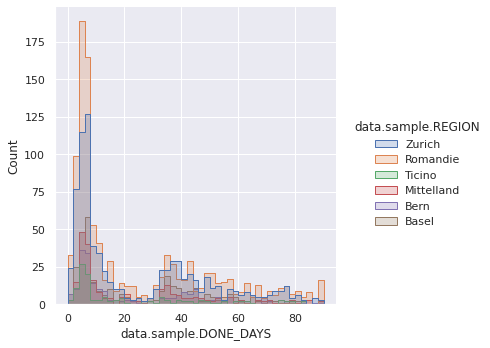

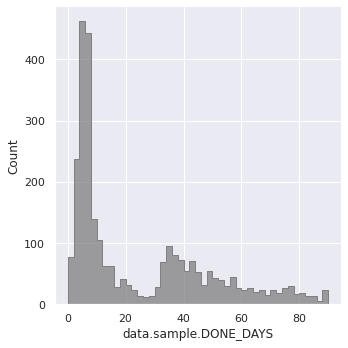

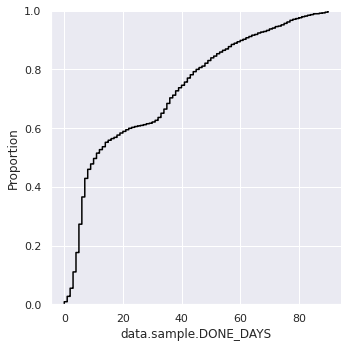

In [4]:
#Number of tasks per delivery date, by region
#Since the differences don't seem too obvious & most of the regions don't have enough data,
#we won't look into that conditional further
sns.displot(df, x = 'data.sample.DONE_DAYS',hue = 'data.sample.REGION', element = 'step',
            binwidth = 2)

# Looking at the overall distribution of the tasks ... Looks like two (or three) lognormals
sns.displot(df_dropped, x = 'data.sample.DONE_DAYS', element = 'step', binwidth = 2, color = 'grey')
sns.displot(df_dropped, x = 'data.sample.DONE_DAYS', kind = 'ecdf', color = 'black')

In [5]:
#Here we consider active tasks, in the sense of a scanline algorithm:
#task 1: ======|=
#task 2:      =|=======
#task 3:       |===
#              ^Scanline : task 3 will enter the active set the next day,
#                          while task 1 will leave it the day after that
#While it does not perfectly capture tasks successfully handed in,
#it does provide an optimal day-to-day view of the tasks

#(APOLOGIES for the list syntax, not fully used to efficient pandas usage anymore)
creation = df['data.sample.CREATION_DATE'].to_list()
completion = df['data.sample.COMPLETION_DATE'].to_list()
due = df['data.sample.DUE_DATE'].to_list()
start = creation[0]
begin = 0
#These are the sets used for tracking the scanline
active = []
active_on_time = []
active_overdue = []
active_old = []
day = []
#These are the sets that track the absolute counts
active_on_time_h = []
active_historic = []
active_14_h = []
active_late = []
finished_h = []
while begin<len(completion) :

  #here we drop all tasks that are completed
  active_old = active.copy()
  active = [x for x in active if start <= completion[x]]
  finished_h.append(len(active_old) - len(active))
  #here we gather all tasks that are entering the scanline at the same date
  oldstart = start
  while oldstart == start and begin < len(completion) :
    oldstart = start
    start = creation[begin]
    active.append(begin)
    begin += 1
  #here we gather the set of tasks that are active and on time
  active_on_time = [x for x in active if start <= due[x]]
  #here we gather the set of tasks that are younger than 14 days, as a proxy for 14-day completion rate
  active_14 = [x for x in active if start <= creation[x] + pd.to_timedelta(14, unit='d')]
  #taking note of the current day
  day.append(start)
  #and in these lines we count the size of these different sets
  active_historic.append(len(active))
  active_on_time_h.append(len(active_on_time))
  active_14_h.append(len(active_14))
  active_late.append(len(active) - len(active_on_time))

on_time_percentage = []
percentage_14 =  []

#And here we figure out the relative percentages
for act, intime, fourt in zip(active_historic, active_on_time_h, active_14_h) :
  on_time_percentage.append(100.0*intime/act)
  percentage_14.append(100.0*fourt/act)

Text(0, 0.5, 'Number of tasks')

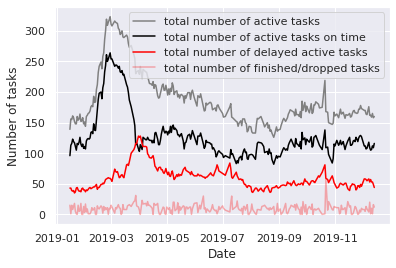

In [6]:
#Here we crop the data, since our view of tasks is rolling, not sharply cut
startw = int((1/12 + 1/36)*len(day))
endw = int(len(day)*23/24)
day_selected = day[startw:endw]

#Here we plot the historical dynamics of the absolute task load
sns.lineplot(x = day_selected, y = active_historic[startw:endw], label = 'total number of active tasks', color = 'grey')
sns.lineplot(x = day_selected, y = active_on_time_h[startw:endw], label = 'total number of active tasks on time', color = 'black')
sns.lineplot(x = day_selected, y = active_late[startw:endw], label = 'total number of delayed active tasks', color = 'red')
sns.lineplot(x = day_selected, y = finished_h[startw:endw], label = 'total number of finished/dropped tasks', color = 'red', alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Number of tasks')

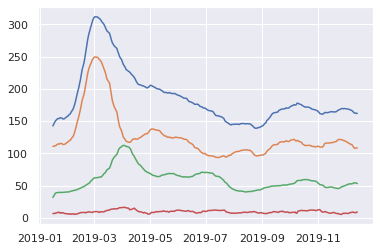

In [7]:
#here we show the smoothed results:
N = 14
act_s = np.convolve(active_historic, np.ones((N,))/N, mode='same')
act_ot_s = np.convolve(active_on_time_h, np.ones((N,))/N, mode='same')
act_lt_s = np.convolve(active_late, np.ones((N,))/N, mode='same')
fin_s = np.convolve(finished_h, np.ones((N,))/N, mode='same')

for smoothed in [act_s, act_ot_s, act_lt_s, fin_s] :
  sns.lineplot(x = day_selected, y = smoothed[startw:endw])

Text(0, 0.5, 'Percentage')

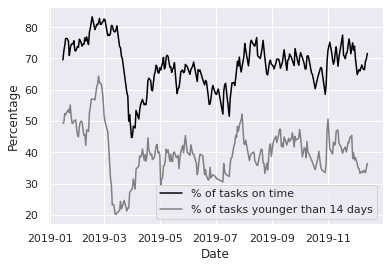

In [7]:
#Here we plot the historical percentage of tasks on time vs. tasks younger than 14 days
sns.lineplot(x = day_selected, y = on_time_percentage[startw:endw], label = '% of tasks on time', color = 'black')  
sns.lineplot(x = day_selected, y = percentage_14[startw:endw], label = '% of tasks younger than 14 days', color = 'grey')
plt.xlabel('Date')
plt.ylabel('Percentage')

In [41]:
#Now we take grouped samples, to get some info about actual completion
#However, in order to preserve temporal information, we only make groups of tasks that are adjacent to each other
#as ordered by creation date
#Giving us in effect sliding-window samples with a fixed window size in regard to the number of samples
#If we kept the window size fixed in regard to the time interval, our number of samples would fluctuate too wildly.
full_completion = []
half_completion = []
quantiles = [.15, .30, .50, .70, .85]
time_to_completion = [[],[],[],[],[]]
new_tasks_given = []
sample_date = []

df = df_dropped #here we use the data without aborted tasks

done_days = df['data.sample.DONE_DAYS'].to_list()
due_days = df['data.sample.DUE_DAYS'].to_list()
creation = df['data.sample.CREATION_DATE'].to_list()
completion = df['data.sample.COMPLETION_DATE'].to_list()
due = df['data.sample.DUE_DATE'].to_list()

no_groups = int(np.sqrt(len(due))) #sqrt(dataset_size) to trade-off sample size vs. number of samples

group_size = int(len(completion) / no_groups)

#We can shift the window by a half group size in order to mitigate cut-off effects
for i in range(2*no_groups-1) :
  group_members = min(group_size, len(completion) - (i/2*group_size))
  half_completed = 0
  full_completed = 0
  completion_time = []
  new_given = 0
  ub = min(int((i/2+1)*group_size), len(completion))
  lb = int(i*group_size/2)
  sample_date.append(df['data.sample.CREATION_DATE'].iloc[lb:ub].median())
  #Here we iterate over all members in the current window
  for j in range(lb, ub) :
    completion_time.append(done_days[j])
    date_14 = creation[j] + pd.to_timedelta(14, unit = 'd')
    date_31 = date_14 + pd.to_timedelta(16, unit = 'd')
    k = j
    while k<len(creation) and creation[k] < date_31 :
      if creation[k] > date_14 :
        new_given += 1
      k += 1
    if done_days[j] <= due_days[j] :
      if done_days[j] <= 14 :
        half_completed +=1
      else :
        full_completed +=1
  full_completion.append(100*float(full_completed)/float(group_members))
  half_completion.append(100*float(half_completed)/float(group_members))
  new_tasks_given.append(float(new_given)/float(group_members))
  for j in range(5) :
    time_to_completion[j].append(np.quantile(completion_time, quantiles[j]))

R is: -0.4823708674561843


(20.0, 80.0)

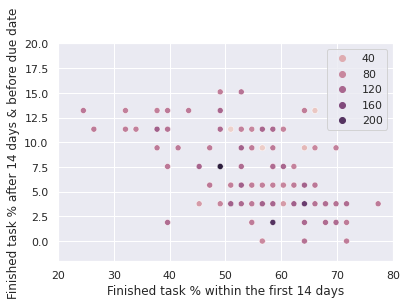

In [78]:
#A Scatterplot to see how the % of early finished tasks correlates with the % of absolutely finished tasks
R, wat = pearsonr(half_completion, full_completion)
print(f'R is: {R}')
sns.scatterplot(x = half_completion, y = full_completion, hue = new_tasks_given)
plt.xlabel('Finished task % within the first 14 days')
plt.ylabel('Finished task % after 14 days & before due date')
plt.ylim(-2, 20)
plt.xlim(20, 80)

R is: 0.9277807043157833


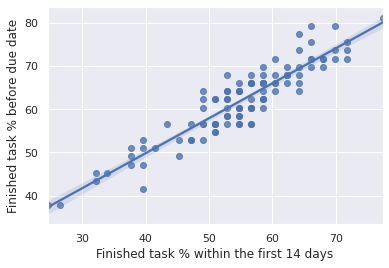

In [47]:
###END OF SERIOUS BUSINESS.
#Following some plots that seemed like a good idea but couldn't be made much sense of
total_completion = np.add(full_completion, half_completion)
sns.regplot(x = half_completion, y = total_completion, robust = True)
plt.xlabel('Finished task % within the first 14 days')
plt.ylabel('Finished task % before due date')
R, wat = pearsonr(half_completion, total_completion)
print(f'R is: {R}')
# Yeah sums of RV's are strongly correlated with the summed RV's. Tell me sth new

Text(0, 0.5, 'time to completion')

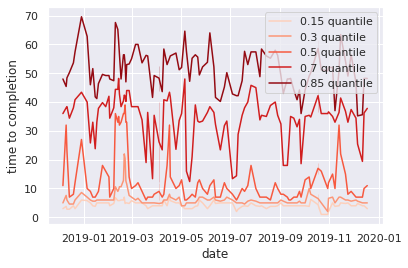

In [48]:
#The resulting plot looks somewhat disconcerting
for i in range(5):
  sns.lineplot(x = sample_date, y = time_to_completion[i], label = f'{quantiles[i]} quantile', color = sequential_colors[1+2*i])
plt.xlabel('date')
plt.ylabel('time to completion')